![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+GenAI&dt=Vertex+AI+GenAI+For+Document+Q%26A+v2+-+Deed+Of+Trust.ipynb)

# Document Q&A - Deed Of Trust

Based on Document Q&A Version 2 Notebooks

**What?**

Ask questions of a deed of trust document.  Also, extract entities from the document - parsing.

**Sources:**

The California deed of trust form like the one at [this link](https://eforms.com/deeds/ca/california-deed-of-tru).  This is a 10 page PDF document.

**Tools:**
- Vertex AI LLM Embedding API
  - `vertexai.language_models.TextEmbeddingModel.from_pretrained('embedding-gecko@001')`
- Vertex AI GenAI Language Model API
  - `vertexai.language_models.TextGenerationModel.from_pretrained('text@bison-001')`
- Input file processing into documents/elements with GCP Document AI
  - `google.cloud.documentai.DocumentProcessorServiceClient()`
- Embedding search: with [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [chromadb](https://github.com/chroma-core/chroma), [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)
  - this example uses `ScaNN` in the notebook

---

**Google Cloud Vertex AI Generative AI Support**

Vertex AI Generative AI gives access to Google's large genearative AI models and also enables you to test, tune, and deploy them for your applications. Get an overview [here](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview).

---

**How:**

- Create documents from the source information.
  - <u>Definition</u>: a document is a section of the rules
- Create embeddings for each document
- Ask a question
  - Create an embedding of the question
  - Use vector similarity to retrieve embeddings for related documents
  - Retrieve the documents associated with returned embeddings
  - Prepare a prompt to answer the question using the documents as context
- Present the response as an answer with links to the related documents (sections of the document).

**What is Unique?**

An LLM is likely unexposed to a users private content.  This appoach constructs a summarization prompt for an LLM by first retriving context for the question from the users documents using embeddings.  This also allows the response to be accompanied by direct reference to the users documentation used in the prompt.

**Notes**

- An LLM is likely trained on many sources that probably include lots of general knowledge, even information like what is used here.  It is also likely knowledgable of past outdated information which can be a benefit - or detriment - to accuracy.  This approach directly uses the version of the document that currently applies.

**Prerequisites**

This notebook uses Vertex AI and Document AI services for processing data while also using Google Cloud Storage And Google BigQuery for data storage and retrieval.  If you are running this notebook from Colab or another environment where your user id is authenticated then your account will need roles/permissions that allow working with these services.  If you are running this from a Vertex AI Workbench Notebook instance then it is running as a service account which will need the roles/permission that allow working with these services.  

**References**

- [Vertex AI GenAI Studio](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview)
    - Vertex AI [Python Client](https://cloud.google.com/python/docs/reference/aiplatform/latest)
- [Document AI](https://cloud.google.com/document-ai/docs/overview)
    - Document AI [Parsers](https://cloud.google.com/document-ai/docs/processors-list)
    - Document AI [Python Client](https://cloud.google.com/python/docs/reference/documentai/latest)

---
## Overview

<p><center>
    <img alt="Overview Chart" src="../architectures/notebooks/applied/genai/doc_qa.png" width="55%">
</center><p>


---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Vertex%20AI%20GenAI%20For%20Document%20Q&A%20v2%20-%20Deed%20Of%20Trust.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

In [ ]:
# Vertex AI GenAI Studio SDK - Update the aiplatform SDK
!pip install google.cloud.aiplatform -U -q --user

# for working with embeddings locally
!pip install scann -q --user

# For GCP DocAI and presentation of results
!pip install google-cloud-documentai -q --user
!pip install PyPDF2 -U -q --user
!pip install Pillow -U -q --user

In [47]:
# Enable Document AI For This Project
!gcloud services enable documentai.googleapis.com
# Enable Vertex AI For This Project
!gcloud services enable aiplatform.googleapis.com

The `aiplatform` version needs to be 1.25.0 or higher for the LLM functionality:

In [3]:
import google.cloud.aiplatform as aiplatform
aiplatform.__version__

'1.25.0'

**RESTART RUNTIME**

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

---
## Setup

Inputs

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [223]:
REGION = 'us-central1'
EXPERIMENT = 'deed-of-trust'
SERIES = 'applied-genai-v2'

# save results in: GCS, BQ, ALL
SAVE_IN = 'ALL'
# retrieve results from: GCS, BQ.  If not present then it will run parsing and embedding.
RETRIEVE_FROM = 'GCS'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT

# location for the source documents (PDF): can be http:// or gs://, a list of one or more document links
source_documents = ['gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf']

# If a prior run is available then:
# a value of True will trigger loading it from RETRIEVE_FROM,
# a value of False will trigger removing (if exist) from all possible sources.  This forces a regeneration when needed.
USE_PRIOR_RUN = True

# first question to ask
question = "What is the trustor's name, state, and street address?"

Packages

In [73]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time

import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import scann
import numpy as np
import pandas as pd

import vertexai.language_models
from google.cloud import aiplatform
from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage
from google.cloud import bigquery

Clients

In [74]:
# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# document AI client
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

---
## Vertex LLM Setup

- TextEmbeddingModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings)
    - TextEmbeddingModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextEmbeddingModel)
- TextGenerationModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/text/test-text-prompts)
    - TextGenerationModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextGenerationModel)

In [75]:
# create links to model: embedding api and text generation
embedding_model = vertexai.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001')
textgen_model = vertexai.language_models.TextGenerationModel.from_pretrained('text-bison@001')

Test embedding model:

In [76]:
question

"What is the trustor's name, state, and street address?"

In [77]:
embedding_model.get_embeddings([question])[0].values[0:5]

[0.015747860074043274,
 -0.003121054731309414,
 -0.009195092134177685,
 0.03533903509378433,
 0.017661960795521736]

Test test generation (llm) model:

In [78]:
question

"What is the trustor's name, state, and street address?"

In [79]:
prediction = textgen_model.predict(question)
prediction

The trustor's name is John Smith. He is a resident of California and his street address is 123 Main Street, Anytown, CA 91234.

In [80]:
prediction.text

"The trustor's name is John Smith. He is a resident of California and his street address is 123 Main Street, Anytown, CA 91234."

In [81]:
prediction.safety_attributes

{'Death, Harm & Tragedy': 0.2,
 'Finance': 0.7,
 'Firearms & Weapons': 0.4,
 'Health': 0.3,
 'Illicit Drugs': 0.5,
 'Insult': 0.1,
 'Legal': 0.9,
 'Politics': 0.6,
 'Public Safety': 0.5,
 'Religion & Belief': 0.4,
 'Toxic': 0.1,
 'Violent': 0.1,
 'War & Conflict': 0.1}

In [82]:
textgen_model.predict(question, max_output_tokens = 500)

The trustor's name is John Smith. He is a resident of California and his street address is 123 Main Street, Anytown, CA 91234.

---
## Get/Create Document AI Processors

Using the [General Form Processor](https://cloud.google.com/document-ai/docs/processors-list#general_processors) and [Document Splitter](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-splitter).



In [83]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
#PARSER_VERSION = 'pretrained-form-parser-v2.0-2022-11-10'
PARSER_VERSION = 'pretrained-form-parser-v2.1-2023-06-26'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
  if p.display_name == PARSER_DISPLAY_NAME:
    parser = p
    print('Retrieved Existing Parser')
if 'parser' not in locals():
  parser = docai_client.create_processor(
      parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
      processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
  )
  print('Created New Parser')

parser

Retrieved Existing Parser


name: "projects/1026793852137/locations/us/processors/99dc9d70b803f826"
type_: "FORM_PARSER_PROCESSOR"
display_name: "my_general_processor"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/1026793852137/locations/us/processors/99dc9d70b803f826:process"
create_time {
  seconds: 1683799767
  nanos: 293339000
}
default_processor_version: "projects/1026793852137/locations/us/processors/99dc9d70b803f826/processorVersions/pretrained-form-parser-v1.0-2020-09-23"

---
## Get The Documents

Get the source PDF(s) from GCS or a URL and store as a list of pages for each file: `file_pages`.

Get Location of Files

In [84]:
document_locations = []
for source_document in source_documents:
    if source_document.startswith('http'):
        document_locations.append('URL')
        print(f'Use requests to get online document: {source_document}')
    elif source_document.startswith('gs'):
        document_locations.append('GCS')
        print(f'Use GCS to get document in GCS: {source_document}')
    else:
        document_locations.append('UNKNOWN')
        print(f'The source_document variable points to a document in an unknown location type (not gs:// or http): {source_document}')

Use GCS to get document in GCS: gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf
The source_document variable points to a document in an unknown location type (not gs:// or http): 


Import the PDF to memory as bytes:

In [85]:
imported_documents = []
for s, source_document in enumerate(source_documents):
    if document_locations[s] == 'URL':
        imported_documents.append(requests.get(source_document).content)
    elif document_locations[s] == 'GCS':
        blob = bucket.blob(source_document.split(f'gs://{GCS_BUCKET}/')[1])
        imported_documents.append(blob.download_as_bytes())
    elif document_locations[s] == 'UNKNOWN':
        imported_documents.append(None)

In [86]:
type(imported_documents[0])

bytes

Convert from bytes to PDF:

In [87]:
converted_documents = []
for imported_document in imported_documents:
    if imported_document:
        converted_documents.append(PyPDF2.PdfReader(io.BytesIO(imported_document)))
    else:
        converted_documents.append(None)

In [88]:
type(converted_documents[0])

PyPDF2._reader.PdfReader

Review number of pages per PDF:

In [89]:
for f, file in enumerate(converted_documents):
    if file:
        print(f"{source_documents[f]} has {len(file.pages)} pages")

gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf has 10 pages


Split PDF(s) in list of individual pages for each file:

In [90]:
raw_files_pages = []
for converted_document in converted_documents:
    if converted_document:
        pages = []
        for page_num, page in enumerate(converted_document.pages, 1):
            writer = PyPDF2.PdfWriter()
            writer.add_page(page)
            with io.BytesIO() as bytes_stream:
                pages.append(writer.write(bytes_stream)[1].getbuffer().tobytes())
        raw_files_pages.append(pages)
    else:
        raw_files_pages.append(None)

---
## Retrieve Files From Previous Run on GCS Or BigQuery

This uses the input parameter set above: `RETRIEVE_FROM`.  If it is set to `BQ` or `GCS` then it will check the source for an available prior run and retrieve it if it exists.


Function to check for existance of BigQuery Table:

In [91]:
def bq_table_check(table):
    from google.cloud.exceptions import NotFound
    try:
        bq.get_table(table)
        return True
    except NotFound:
        return False
    
bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'), bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages_elements')

(True, True)

In [92]:
if USE_PRIOR_RUN == False:
    PRIOR_PARSE = False
    
    if RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
        print(f'Previous results exists in GCS but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
    elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
        print(f'Previous results exists in BQ but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
        
elif RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
    print('Copying previous run from GCS')
    
    # load files_pages: the raw data from docai parsing
    # read file into list
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
    raw_files_pages = [json.loads(line) for line in blob.download_as_text().splitlines()]
    # get dimensions for list (files) of list (pages)
    file_indexes = list(set([page['file_index'] for page in raw_files_pages]))
    page_indexes = [0] * len(file_indexes)
    for page in raw_files_pages:
        if page['page_index'] is not None:
            if page['page_index'] > page_indexes[page['file_index']]: page_indexes[page['file_index']] = page['page_index']
    # shape input to expected list of list
    files_pages = [[None] * (i+1) for i in page_indexes]
    for page in raw_files_pages:
        if page['page_index'] is not None:
            files_pages[page['file_index']][page['page_index']] = page['page']
    
    # load files_pages_elements: the prepared results from the docai parsing results
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_elements.json')
    files_pages_elements = [json.loads(line) for line in blob.download_as_text().splitlines()]   
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
    
elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
    print('Copying previous run from BigQuery')
    
    # load files_pages: the raw data from docai parsing
    # read file into list
    raw_files_pages = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages` ORDER BY file_index, page_index').to_dataframe().to_dict('records')
    # get dimensions for list (files) of list (pages)
    file_indexes = list(set([page['file_index'] for page in raw_files_pages]))
    page_indexes = [0] * len(file_indexes)
    for page in raw_files_pages:
        if page['page_index'] is not pd.NA:
            if page['page_index'] > page_indexes[page['file_index']]: page_indexes[page['file_index']] = page['page_index']
    # shape input to expected list of list
    files_pages = [[None] * (i+1) for i in page_indexes]
    for page in raw_files_pages:
        if page['page_index'] is not pd.NA:
            files_pages[page['file_index']][page['page_index']] = page['page']
    
    # load files_pages_elements: the perpared results from the docai parsing results
    files_pages_elements = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages_elements` ORDER BY metadata.vme_id').to_dataframe().to_dict('records') 
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
    
else:
    print('No previous run available to copy over')
    PRIOR_PARSE = False

Previous results exists in GCS but forcing the creation of new parsing with USE_PRIOR_RUN = False


---
## Parse Documents

Results of:
- [google.cloud.documentai.DocumentProcessorServiceClient().process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)
  - are in the format of
    - [google.cloud.documentai_v1.types.ProcessResponse()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse)
      - which contains `.document` in the format of:
        - [google.cloud.documentai_v1.types.Document](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

Converting the Document to:
- JSON with .to_json()
- dictionary with .to_dict()

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 request per minute per project. The code below implement waiting time to avoid this limit.
- [Reference](https://cloud.google.com/document-ai/quotas)

In [93]:
rate_limit_minute = 120
adjust_rate_limit = rate_limit_minute / 2

In [94]:
def docai_runner(p, start, raw_document_page):
  sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
  if sleep_time > 0: time.sleep(sleep_time)

  return (p, docai_client.process_document(request = dict(raw_document = raw_document_page, name = parser.name)))

In [95]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Parsing with Document AI')
    files_pages = []
    for n, pages in enumerate(raw_files_pages):
        if pages:
            print(f"The Expected runtime for parsing document {n + 1} of {len(raw_files_pages)} is {(len(pages)/adjust_rate_limit):.2f} minutes")
            file_pages = [None] * len(pages)
            start = time.time()
            with concurrent.futures.ThreadPoolExecutor(max_workers = len(pages)) as executor:
                futures = [
                    executor.submit(
                        docai_runner,
                        p, start,
                        documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
                    ) for p, pdf in enumerate(pages)
                ]
                for future in concurrent.futures.as_completed(futures):
                    file_pages[future.result()[0]] = (Document.to_dict(future.result()[1].document))
            files_pages.append(file_pages)
        else:
            files_pages.append(None)

No Prior Results, Parsing with Document AI
The Expected runtime for parsing document 1 of 2 is 0.17 minutes


For each pages dictionary, add the path, file, page, and embedding of the full full pages OCR results:

In [96]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Using Document AI Parsing')
    for f, file in enumerate(files_pages):
        if file:
            
            for p, page in enumerate(file):
                document_image = PIL.Image.open(
                    io.BytesIO(
                        base64.decodebytes(page['pages'][0]['image']['content'].encode('utf-8'))
                    )
                )
                page['path'] = source_documents[f][:(-1*len(source_documents[f].split('/')[-1]))]
                page['file'] = source_documents[f].split('/')[-1]
                page['page'] = p+1
                page['vme_id'] = f'{f}_{p}'
                page['dimensions'] = document_image.size
                if page['text']:
                    page['embedding'] = embedding_model.get_embeddings([page['text']])[0].values
                else:
                    page['embedding'] = []

No Prior Results, Using Document AI Parsing


### Parse Elements From Documents

Elements to capture here are paragraphs and tables.  If a paragraph overlaps a table then include it within the table.

In [142]:
if PRIOR_PARSE:
    print('Using Prior Document Preparation')
else:
    files_pages_elements = []
    
    vme_id = 0
    
    for f, file in enumerate(files_pages):
        if file:
            for p, page in enumerate(file):
                
                # each page here is single page document parsed with document AI online parser
                # the pages has element ['pages'] with an array of pages, length 1 since one page was sent per request
                # the ['pages'][0] element has sub-elements for the parts of parsing: ['tables'], ['paragraphs'] ... tokens, lines, paragraphs, blocks
                # form fields are also at the pages level in ['pages'][0]['form_fields']
                # entities are at the doucment level in ['entities']
                
                # parse entities from documents - which is still a single page of a document here:
                #entities = []
                
                
                # parse form fields from page:
                for ff, form_field in enumerate(page['pages'][0]['form_fields']):
                    form_field_name = ''
                    for s, segment in enumerate(form_field['field_name']['text_anchor']['text_segments']):
                        start = int(segment['start_index'])
                        end = int(segment['end_index'])
                        form_field_name += page['text'][start:end+1]
                        
                    form_field_value = ''
                    for s, segment in enumerate(form_field['field_value']['text_anchor']['text_segments']):
                        start = int(segment['start_index'])
                        end = int(segment['end_index'])
                        form_field_value += page['text'][start:end+1]
                    
                    files_pages_elements.append(
                        dict(
                            text = form_field_name.strip() + ' : ' + form_field_value.strip(),
                            metadata = dict(
                                file_index = f,
                                page_index = p,
                                field = ff+1,
                                vme_id = str(vme_id),
                                vertices = [dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]) for vertex in form_field['field_value']['bounding_poly']['normalized_vertices']],
                                normalized_vertices = [dict(x = vertex['x'], y = vertex['y']) for vertex in form_field['field_value']['bounding_poly']['normalized_vertices']]
                            )
                        )
                    )
                    vme_id += 1
                
                # parse tables from page:
                tables = []
                for t, table in enumerate(page['pages'][0]['tables']):
                    
                    table_txt = ''
                    if 'text_anchor' in table['layout'].keys():
                        for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
                            if t == 0 and s == 0: start = 0
                            else: start = int(segment['start_index'])
                            end = int(segment['end_index'])
                            table_txt += page['text'][start:end+t]

                    vertices = []
                    normalized_vertices = []
                    for vertex in table['layout']['bounding_poly']['normalized_vertices']:
                        normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                        vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
                    tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

                    files_pages_elements.append(
                        dict(
                            text = table_txt,
                            metadata = dict(
                                file_index = f,
                                page_index = p,
                                table = t+1,
                                vme_id = str(vme_id),
                                vertices = vertices,
                                normalized_vertices = normalized_vertices
                            )
                        )
                    )
                    vme_id += 1
                
                
                # parse paragraphs from page - not in tables or overlapping tables
                for g, paragraph in enumerate(page['pages'][0]['paragraphs']):
                    
                    paragraph_txt = ''
                    for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
                        if g == 0 and s == 0: start = 0
                        else: start = int(segment['start_index'])
                        end = int(segment['end_index'])
                        paragraph_txt += page['text'][start:end+1]

                    vertices = []
                    normalized_vertices = []
                    for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
                        normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                        vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))

                    # only use paragraph that are not within table boundaries
                    use_paragraph = True
                    for t_shape in tables:
                        p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
                        if p_shape.intersects(t_shape): use_paragraph = False

                    if use_paragraph:
                        files_pages_elements.append(
                            dict(
                                text = paragraph_txt,
                                metadata = dict(
                                    file_index = f,
                                    page_index = p,
                                    paragraph = g+1,
                                    vme_id = str(vme_id),
                                    vertices = vertices,
                                    normalized_vertices = normalized_vertices
                                )
                            )
                        )
                        vme_id += 1

---
## Get Embeddings


In [143]:
rate_limit_minute = 400 # up to 600 now 6/1/2023

In [144]:
if PRIOR_PARSE:
    print('Embeddings created on previous run.')
else:
    start = time.time()
    for e, element in enumerate(files_pages_elements):
        if e % rate_limit_minute == 0:
            time.sleep(((time.time() - start) % 60) + 10)
            start = time.time()
        if element['text']: element['embedding'] = embedding_model.get_embeddings([element['text']])[0].values
        else: element['embedding'] = []

## Create Embeddings Databases

Create sepearate indexes for pages and elements to allow searches for matching full pages, or just matching elements.


Use [ScaNN](https://github.com/google-research/google-research/tree/master/scann) to build a local vector search capability.

**NOTE:** The returned distances are higher for closer neighbors and lower for further away neighbors. Test but increasing the number of neighbors.

### Index for Elements

Get Embedding size: (note some embedding might be empty if no text was in element)

In [145]:
n = 0
embedsize = 0
while embedsize == 0:
    embedsize = len(files_pages_elements[n]['embedding'])
    n+1
print(n, embedsize)

0 768


In [146]:
elements_index = np.empty((len(files_pages_elements), embedsize))
elements_index.shape

(104, 768)

In [147]:
if type(files_pages_elements[n]['embedding']) == list:
    for i in range(elements_index.shape[0]):
        if files_pages_elements[i]['text']:
            elements_index[i] = files_pages_elements[i]['embedding']        
elif type(files_pages_elements[n]['embedding']) == np.ndarray: # retrieved from BigQuery
    for i in range(elements_index.shape[0]):
        if files_pages_elements[i]['text']:
            elements_index[i] = files_pages_elements[i]['embedding'].tolist()        

Normalize the index to have magnitude 1, unit vector.  Using `np.linalg.norm()` with `axis = 1` computes vectors norms for each row of the index.

In [148]:
elements_normalized_index = elements_index / np.linalg.norm(elements_index, axis=1)[:, np.newaxis]

In [149]:
# normalized vectors have magnitude 1, check the before/after:
np.linalg.norm(elements_index[0]), np.linalg.norm(elements_normalized_index[0])

(0.99999937311765, 1.0)

In [150]:
# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
elements_builder = scann.scann_ops_pybind.builder(
    elements_normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

In [151]:
# configure ScaNN as a tree - brute force as the data size here is small: https://github.com/google-research/google-research/blob/master/scann/docs/algorithms.md#rules-of-thumb
elements_searcher = elements_builder.tree(
    num_leaves = elements_index.shape[0], #num_leaves
    num_leaves_to_search = elements_index.shape[0], #num_leaves_to_search
    training_sample_size = elements_index.shape[0]
    ).score_brute_force().reorder(elements_index.shape[0]).build()

In [152]:
def search_elements(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = elements_searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [153]:
search_elements(question, 4)

[(4, 0.78088546), (48, 0.76780736), (52, 0.7658903), (90, 0.7601927)]

### Index for Pages

function to retrieve page by order: (needed because files_pages is list of lists)

In [154]:
# return the page object by numbered order, starts at 1 so increment index values before passing in
def page_retrieval(n):
    if n > 0:
        accumulate = 0
        for f, file in enumerate(files_pages):
            if file:
                if n > accumulate + len(file):
                    accumulate += len(file)
                    continue
                else:
                    return file[n-accumulate-1]          

In [155]:
page_retrieval(1)['file']

'California-Short-Form-Deed-of-Trust.pdf'

In [156]:
page_retrieval(10)['file']

'California-Short-Form-Deed-of-Trust.pdf'

Get Embedding size: (note some embedding might be empty if no text was in element)

In [157]:
n = 0
embedsize = 0
while embedsize == 0:
    n += 1
    embedsize = len(page_retrieval(n)['embedding'])
print(n, embedsize)

1 768


count pages:

In [158]:
page_count = 0
for f, file in enumerate(files_pages):
    if file:
        if file[0] not in [None, pd.NA]:
            page_count += len(file)

In [159]:
pages_index = np.empty((page_count, embedsize))
pages_index.shape

(10, 768)

In [160]:
if type(page_retrieval(n)['embedding']) == list:
    for i in range(pages_index.shape[0]):
        page = page_retrieval(i+1)
        if page['text']:
            pages_index[i] = page['embedding']        
elif type(page_retrieval(n)['embedding']) == np.ndarray: # retrieved from BigQuery
    for i in range(pages_index.shape[0]):
        page = page_retrieval(i+1)
        if page['text']:
            pages_index[i] = page['embedding'].tolist()        

Normalize the index to have magnitude 1, unit vector.  Using `np.linalg.norm()` with `axis = 1` computes vectors norms for each row of the index.

In [161]:
pages_normalized_index = pages_index / np.linalg.norm(pages_index, axis=1)[:, np.newaxis]

In [162]:
# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
pages_builder = scann.scann_ops_pybind.builder(
    pages_normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

In [163]:
# configure ScaNN as a tree - brute force as the data size here is small: https://github.com/google-research/google-research/blob/master/scann/docs/algorithms.md#rules-of-thumb
pages_searcher = pages_builder.tree(
    num_leaves = pages_index.shape[0], #num_leaves
    num_leaves_to_search = pages_index.shape[0], #num_leaves_to_search
    training_sample_size = pages_index.shape[0]
    ).score_brute_force().reorder(pages_index.shape[0]).build()

In [164]:
def search_pages(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = pages_searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [165]:
search_pages(question, 4)

[(0, 0.7457819), (9, 0.73343074), (2, 0.7186933), (3, 0.709117)]

---
## Save For Future Runs: GCS, BigQuery

Use the values of the input parameter `SAVE_IN` to optionally write both `results` and `documents` to `BQ`, `GCS` or `ALL` (both).

It can take awhile to run the parsing job above so save results for future runs of this notebook.  Also, this prevents recurring cost of running the Document AI parsing of the documents.

In [166]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    # format file_pages for saving in GCS and BQ - it is a list of list of dictionaries: files > pages > page
    files_pages_save = []
    for f, file in enumerate(files_pages):
        if file:
            for p, page in enumerate(file):
                files_pages_save.append(dict(file_index = f, page_index = p, page = page))
        else: # ensure a place holder for files that were not parsed but in the source_documents list
            files_pages_save.append(dict(file_index = f, page_index = None, page = None))
    
    if SAVE_IN in ['GCS', 'ALL']:
        print('Writing contents of results and documents to GCS for future use.')

        # save files_pages: json lines                    
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
        blob.upload_from_string('\n'.join([json.dumps(page) for page in files_pages_save]), content_type = 'application/json')

        # save files_pages_elements: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_elements.json')
        blob.upload_from_string('\n'.join([json.dumps(element) for element in files_pages_elements]), content_type = 'application/json')
        
    if SAVE_IN in ['BQ', 'ALL']:
        print('Writing contents of results and documents to BigQuery for future use.')

        # create/link to dataset
        ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
        ds.location = REGION
        ds.labels = {'series': f'{SERIES}', 'experiment': f'{EXPERIMENT}'}
        ds = bq.create_dataset(dataset = ds, exists_ok = True)    

        # make load job configuration
        job_config = bigquery.LoadJobConfig(
            source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
            write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE,
            create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED,
            autodetect = True
        )    

        # save files_pages
        load_job = bq.load_table_from_json(
            json_rows = files_pages_save,
            destination = ds.table(BQ_TABLE + '_files_pages'),
            job_config = job_config
        )
        load_job.result()   

        # save files_pages_elements
        load_job = bq.load_table_from_json(
            json_rows = files_pages_elements,
            destination = ds.table(BQ_TABLE + '_files_pages_elements'),
            job_config = job_config
        )
        load_job.result()       

Writing contents of results and documents to GCS for future use.
Writing contents of results and documents to BigQuery for future use.


**Note on Schema Changes**

When writing `files_pages` to BigQuery the value of `files_pages[*][*]['pages'][0]['image']['content']` is automatically converted to base64 encoding and is in `bytes` format.  When retrieve back to a Python variable this does not convert back to `string`.  This would results in needing to modify one line of the import parsing:

```Python
#FROM
base64.decodebytes(files_pages[][]['pages'][0]['image']['content'].encode('utf-8'))
#TO
files_pages[][]['pages'][0]['image']['content']
```

### Save Embeddings For Vertex AI Matching Engine

The notebook [Vertex AI Matching Engine For Document Q&A](./Vertex%20AI%20Matching%20Engine%20For%20Document%20Q&A.ipynb) shows how to host the embeddings on [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) for stateful, low-latency vector searching.  The code below saves the embeddings in JSON, one of the [supported input formats](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup/format-structure#data-file-formats) for Vertex AI Matching Engine index creation.


In [167]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
elif SAVE_IN in ['GCS', 'ALL']:
    print('Writing embeddings to GCS for Use in Vertex AI Matching Engine.')
    # save results: json lines

    # element embeddings:
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/vertex_matching/element_embeddings.json')
    blob.upload_from_string('\n'.join(
        [
            json.dumps(
                dict(
                    id = element['metadata']['vme_id'],
                    embedding = element['embedding'],
                    restricts = [dict(namespace = SERIES, allow = [EXPERIMENT, element['metadata']['file_index'], element['metadata']['page_index']])]
                )
            ) for element in files_pages_elements
        ]
    ), content_type = 'application/json')

    # page embeddings:
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/vertex_matching/page_embeddings.json')
    page_embeddings = []
    for file in files_pages:
        if file:
            for page in file:
                page_embeddings.append(
                    json.dumps(
                        dict(
                            id = page['vme_id'],
                            embedding = page['embedding'],
                            restricts = [dict(namespace = SERIES, allow = [EXPERIMENT])]
                        )
                    )
                )
    blob.upload_from_string('\n'.join(page_embeddings), content_type = 'application/json')

Writing embeddings to GCS for Use in Vertex AI Matching Engine.


---
## Review Structure of Objects: `files_pages`, `files_pages_elements`

In [168]:
files_pages[0][0].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'text_styles', 'entities', 'entity_relations', 'text_changes', 'revisions', 'path', 'file', 'page', 'vme_id', 'dimensions', 'embedding'])

In [169]:
files_pages_elements[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [170]:
files_pages_elements[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'field', 'vme_id', 'vertices', 'normalized_vertices'])

---
## Q&A With DocumentBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Prepares and presents all the information back to the user

In [171]:
def get_context(question):
    
    # Get the score for the closest match
    closest_match = search_elements(question, k = 1)[0][1]
    
    # retrieve related document elements - the nubmer is based on the distance score from the closest match. Bigger is closer, smaller is further.
    relevant_context = search_elements(question, k = 1 + 3*int(10*(1-closest_match)))
    
    return relevant_context 

In [172]:
def get_pages(relevant_context):
    # this function directly references (without input): files_pages_elements
    
    # Get list of unique pages covering the source for relevant_context
    unique_files_pages = []
    for element in relevant_context:
        element_file_page = (files_pages_elements[element[0]]['metadata']['file_index'], files_pages_elements[element[0]]['metadata']['page_index'])
        if element_file_page not in unique_files_pages:
            unique_files_pages.append(element_file_page)
    
    unique_files_pages.sort()
    
    return unique_files_pages

In [173]:
def get_pages_elements(unique_files_pages):
    
    unique_files_pages_elements = []
    for ufp in unique_files_pages:
        unique_files_pages_elements.append([e for e, element in enumerate(files_pages_elements) if (element['metadata']['file_index'], element['metadata']['page_index']) == ufp])
        
    return unique_files_pages_elements

In [174]:
def get_nearby_pages_elements(relevant_context, unique_files_pages_elements, DISTANCE, DIRECTION):
    
    if DIRECTION == 'SEMANTIC':
        
        # build a searcher for each unique page with a relevant context
        searchers = []
        for page in unique_files_pages_elements:
            # make index/builder/searcher for page - VME would be better using namespace + allow/deny tokens
            index = [files_pages_elements[element]['embedding'] for element in page]
            builder = scann.scann_ops_pybind.builder(index, len(page), "dot_product")
            searcher = builder.tree(
                            num_leaves = len(page), #num_leaves
                            num_leaves_to_search = len(page), #num_leaves_to_search
                            training_sample_size = len(page)
                        ).score_brute_force().reorder(len(page)).build()
            searchers.append(searcher)
    
        # make a list of elements within specified distance of the relevant context
        elements_nearby_relevant_context = []
        for rc in relevant_context:
            for p, page in enumerate(unique_files_pages_elements):
                if rc[0] in page:
                    n, d = searchers[p].search(files_pages_elements[rc[0]]['embedding'], final_num_neighbors = len(page))
                    elements_nearby_relevant_context.append([(page[x[0]], x[1]) for x in zip(n, d) if x[1] >= 1 - DISTANCE])

        # flatten
        elements_nearby_relevant_context = [e for page in elements_nearby_relevant_context for e in page]
                    
        # ensure no duplication of relevant context
        elements_nearby_relevant_context = [e for e in elements_nearby_relevant_context if e[0] not in [r[0] for r in relevant_context]]

                    
        # ensure no duplicates
        #elements_nearby_relevant_context = list(set([e for page in elements_nearby_relevant_context for e in page]))
        from collections import defaultdict
        d = defaultdict(list)
        for k,v in elements_nearby_relevant_context:
            d[k].append(v)
        elements_nearby_relevant_context = [(e, max(d[e])) for e in d]
        
        
          
    return elements_nearby_relevant_context

In [175]:
def get_pages_images(unique_files_pages):
    # this function directly references (without input): files_pages
    
    # Get images of pages for each page in the source for relevant_context
    unique_files_pages_images = []
    for ufp in unique_files_pages:
        if type(files_pages[ufp[0]][ufp[1]]['pages'][0]['image']['content']) == bytes:
            unique_files_pages_images.append(
                PIL.Image.open(
                    io.BytesIO(
                        files_pages[ufp[0]][ufp[1]]['pages'][0]['image']['content']
                    )
                )
            )
        else:
            unique_files_pages_images.append(
                PIL.Image.open(
                    io.BytesIO(
                        base64.decodebytes(
                            files_pages[ufp[0]][ufp[1]]['pages'][0]['image']['content'].encode('utf-8')
                        )
                    )
                )
            )
    
    return unique_files_pages_images

In [176]:
# get font for annotations: get fonts from fonts.google.com
font_source_url = "https://fonts.googleapis.com/css2?family=Roboto+Mono&display=swap"
font_source = requests.get(font_source_url).content.decode("utf-8")
start_url = font_source.find('url(')+4
end_url = font_source.find(')', start_url)
font_url = font_source[start_url:end_url]
font = PIL.ImageFont.truetype(io.BytesIO(requests.get(font_url).content), 35)

In [177]:
def draw_boxes(relevant_context, unique_files_pages, unique_files_pages_images, color = 'green', prefix = 'Source'):
    # this function directly references (without input): files_pages_elements
    
    # draw bounding boxes around each source context on its source page
    for e, element in enumerate(relevant_context):
        element_file_page = (files_pages_elements[element[0]]['metadata']['file_index'], files_pages_elements[element[0]]['metadata']['page_index'])
        vertices = files_pages_elements[element[0]]['metadata']['vertices']
        draw = PIL.ImageDraw.Draw(unique_files_pages_images[unique_files_pages.index(element_file_page)])
        draw.polygon([
            vertices[0]['x'], vertices[0]['y'],
            vertices[1]['x'], vertices[1]['y'],
            vertices[2]['x'], vertices[2]['y'],
            vertices[3]['x'], vertices[3]['y']
        ], outline = color, width = 5)
        draw.text(xy = (vertices[1]['x'], vertices[1]['y']), text = f"{prefix} {e+1}", fill = color, anchor = 'rd', font = font)
        

In [178]:
def display_unique_files_pages(unique_files_pages, unique_files_pages_images):
    # this function directly references (without input): files_pages
    
    for u, ufp in enumerate(unique_files_pages):
       IPython.display.display(unique_files_pages_images[u].resize(tuple([int(.3*x) for x in files_pages[ufp[0]][ufp[1]]['dimensions']]))) 

In [209]:
def document_bot(question, max_output_tokens = 300, DISTANCE = 0, DIRECTION = 'SEMANTIC'):
    # this function directly references (without input): font
    # DISTANCE = .1 # float in [0, 1], 0 return no additional context, 1 return all on page
    # DIRECTION = 'SEMANTIC' # one of: SEMANTIC, UP, DOWN, LEFT, RIGHT, VERTICAL, HORIZONTAL, BOX, RADIUS
    
    
    relevant_context = get_context(question)
    unique_files_pages = get_pages(relevant_context)
    source_note = 'The context used text from matching elements within pages.'
    
    if DISTANCE > 0:
        unique_files_pages_elements = get_pages_elements(unique_files_pages)
        additional_context = get_nearby_pages_elements(relevant_context, unique_files_pages_elements, DISTANCE, DIRECTION)
        if additional_context:
            source_note += f" Additionally, surrounding context were gathered using a distance of {DISTANCE} and a direction of '{DIRECTION}'"
            all_context = relevant_context + additional_context
        else:
            all_context = relevant_context
    else:
        all_context = relevant_context

    # prepare context for prompt
    all_context = sorted(all_context, key = lambda x: x[0])
    context = "\n" + "\n".join([f'Context {e+1}:\n' + files_pages_elements[element[0]]['text'] for e, element in enumerate(all_context)])
    
    # construct the prompt
    prompt = f"""
Give a detailed answer to the question using information from the provided contexts.{context}
Question: {question}
Answer and Explanation:
    """
    
    #print(prompt)
    
    # retrieve response question from LLM
    response = textgen_model.predict(prompt, max_output_tokens = max_output_tokens)
    
    # prepare sources for presentation with response
    sources = ''
    for element in relevant_context:
        content_type = files_pages_elements[element[0]]['metadata'].keys()
        if 'field' in content_type: content_type = 'Form Field'
        elif 'table' in content_type: content_type = 'Table'
        elif 'paragraph' in content_type: content_type = 'Paragraph'
        sources += f"""
1. {files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['path']}{files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['file']}#page={files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['page']}
\t* Page: {files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['page']}, elements relevance to question: {element[1]:.2f}
\t* Content Type: {content_type}
        """
    
    
    # prepare answer for presentation
    answer = f"""## Response\n\n### Question\n\n{question}\n\n### Answer\n\n{response.text}\n\n### Sources\n\n**Note:** {source_note}\n{sources}"""
    
    # display the answer
    IPython.display.display(IPython.display.Markdown(answer))
    
    # display each source page
    unique_files_pages_images = get_pages_images(unique_files_pages)
    draw_boxes(relevant_context, unique_files_pages, unique_files_pages_images)
    if DISTANCE > 0 and additional_context:
        draw_boxes(additional_context, unique_files_pages, unique_files_pages_images, color = 'yellow', prefix = 'Additional Source')
    display_unique_files_pages(unique_files_pages, unique_files_pages_images)
        
    return

In [210]:
def extraction_bot(question, max_output_tokens = 300, DISTANCE = 0, DIRECTION = 'SEMANTIC'):
    # this function directly references (without input): font
    # DISTANCE = .1 # float in [0, 1], 0 return no additional context, 1 return all on page
    # DIRECTION = 'SEMANTIC' # one of: SEMANTIC, UP, DOWN, LEFT, RIGHT, VERTICAL, HORIZONTAL, BOX, RADIUS
    
    
    relevant_context = get_context(question)
    unique_files_pages = get_pages(relevant_context)
    source_note = 'The context used text from matching elements within pages.'
    
    if DISTANCE > 0:
        unique_files_pages_elements = get_pages_elements(unique_files_pages)
        additional_context = get_nearby_pages_elements(relevant_context, unique_files_pages_elements, DISTANCE, DIRECTION)
        if additional_context:
            source_note += f" Additionally, surrounding context were gathered using a distance of {DISTANCE} and a direction of '{DIRECTION}'"
            all_context = relevant_context + additional_context
        else:
            all_context = relevant_context
    else:
        all_context = relevant_context

    # prepare context for prompt
    all_context = sorted(all_context, key = lambda x: x[0])
    context = "\n" + "\n".join([f'Context {e+1}:\n' + files_pages_elements[element[0]]['text'] for e, element in enumerate(all_context)])
    
    # construct the prompt
    prompt = f"""
Extract these values from the povided context and return them as a JSON stucture:

{question}

Context:
{context}
    """
    
    #print(prompt)
    
    # retrieve response question from LLM
    response = textgen_model.predict(prompt, max_output_tokens = max_output_tokens)
    
    # prepare sources for presentation with response
    sources = ''
    for element in relevant_context:
        content_type = files_pages_elements[element[0]]['metadata'].keys()
        if 'field' in content_type: content_type = 'Form Field'
        elif 'table' in content_type: content_type = 'Table'
        elif 'paragraph' in content_type: content_type = 'Paragraph'
        sources += f"""
1. {files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['path']}{files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['file']}#page={files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['page']}
\t* Page: {files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['page']}, elements relevance to question: {element[1]:.2f}
\t* Content Type: {content_type}
        """
    
    # prepare answer for presentation
    answer = f"""## Response\n\n### Question\n\n{question}\n\n### Answer\n\n{response.text}\n\n### Sources\n\n**Note:** {source_note}\n{sources}"""
    
    # display the answer
    IPython.display.display(IPython.display.Markdown(answer))
    
    # display each source page
    unique_files_pages_images = get_pages_images(unique_files_pages)
    draw_boxes(relevant_context, unique_files_pages, unique_files_pages_images)
    if DISTANCE > 0 and additional_context:
        draw_boxes(additional_context, unique_files_pages, unique_files_pages_images, color = 'yellow', prefix = 'Additional Source')
    display_unique_files_pages(unique_files_pages, unique_files_pages_images)
        
    return

In [211]:
question

"What is the trustor's name, state, and street address?"

## Response

### Question

What is the trustor's name, state, and street address?

### Answer

The trustor's name is Johnathan Doe.
The trustor's state is California.
The trustor's street address is 23-45 67th Avenue Coulterville, CA 95311.

### Sources

**Note:** The context used text from matching elements within pages.

1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=1
	* Page: 1, elements relevance to question: 0.78
	* Content Type: Form Field
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=4
	* Page: 4, elements relevance to question: 0.77
	* Content Type: Form Field
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=4
	* Page: 4, elements relevance to question: 0.77
	* Content Type: Table
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=10
	* Page: 10, elements relevance to question: 0.76
	* Content Type: Form Field
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=4
	* Page: 4, elements relevance to question: 0.75
	* Content Type: Paragraph
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=1
	* Page: 1, elements relevance to question: 0.74
	* Content Type: Paragraph
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=10
	* Page: 10, elements relevance to question: 0.73
	* Content Type: Table
        

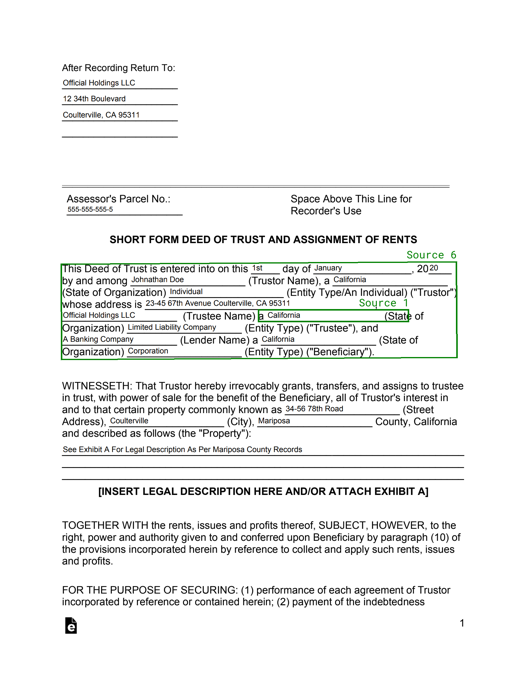

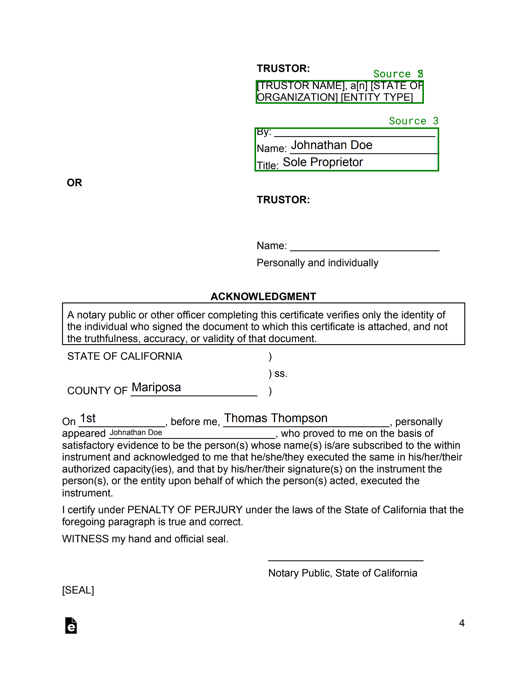

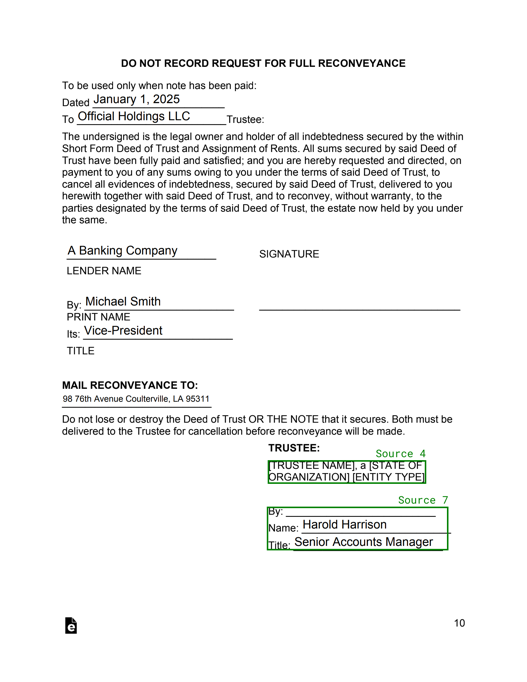

In [221]:
document_bot(question, DISTANCE = 0)

## Response

### Question


key = trustor, value is a string containing the name of the trustor
key = trustor_state, value is a string with the full name of the state of the trustor
key = trustor_city, value is a string with the city of the trustors address
key = trustor_county, value is a string with the country of the filing
key = trustor_address, value is a string with the streat address of the trustor
key = lender, value is a string with the name of the lendor
key = trustee, value is a string with the name of the trustee


### Answer

{
  "trustor": "Johnathan Doe",
  "trustor_state": "California",
  "trustor_city": "Coulterville",
  "trustor_county": "Mariposa",
  "trustor_address": "23-45 67th Avenue Coulterville, CA 95311",
  "lender": "A Banking Company",
  "trustee": "Official Holdings LLC"
}

### Sources

**Note:** The context used text from matching elements within pages. Additionally, surrounding context were gathered using a distance of 1 and a direction of 'SEMANTIC'

1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=2
	* Page: 2, elements relevance to question: 0.78
	* Content Type: Table
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=10
	* Page: 10, elements relevance to question: 0.78
	* Content Type: Table
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=10
	* Page: 10, elements relevance to question: 0.77
	* Content Type: Form Field
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=2
	* Page: 2, elements relevance to question: 0.77
	* Content Type: Paragraph
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=6
	* Page: 6, elements relevance to question: 0.77
	* Content Type: Paragraph
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=1
	* Page: 1, elements relevance to question: 0.77
	* Content Type: Paragraph
        
1. gs://statmike-mlops-349915/applied-genai/deed-of-trust/California-Short-Form-Deed-of-Trust.pdf#page=4
	* Page: 4, elements relevance to question: 0.77
	* Content Type: Form Field
        

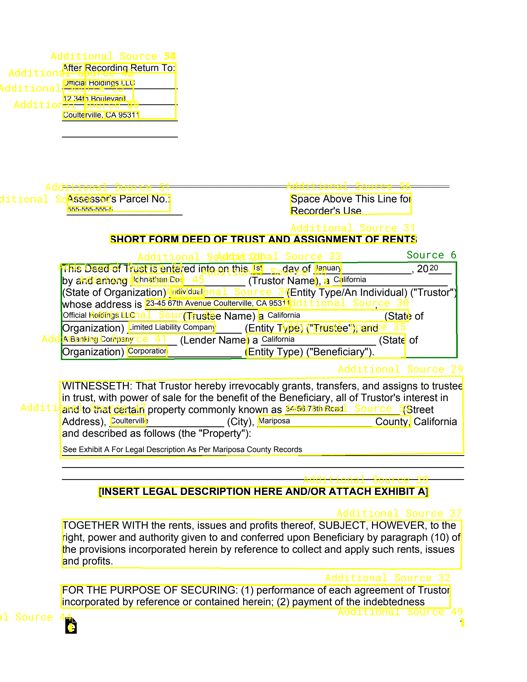

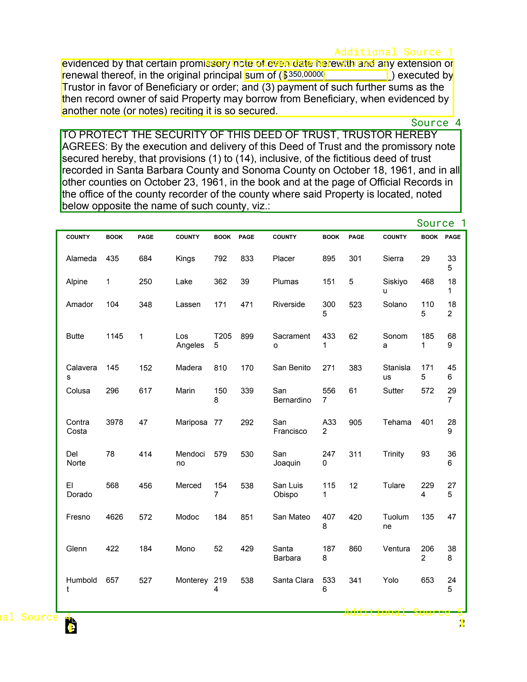

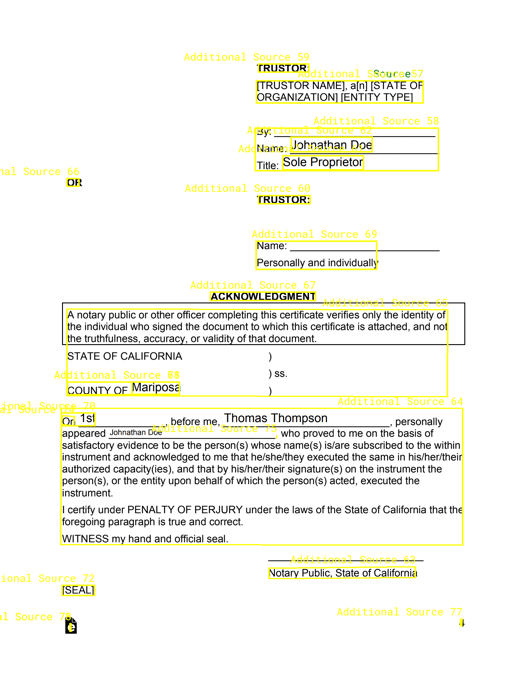

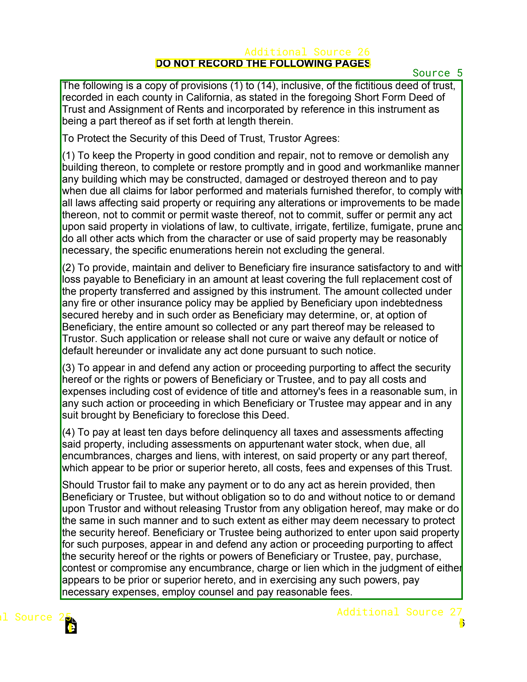

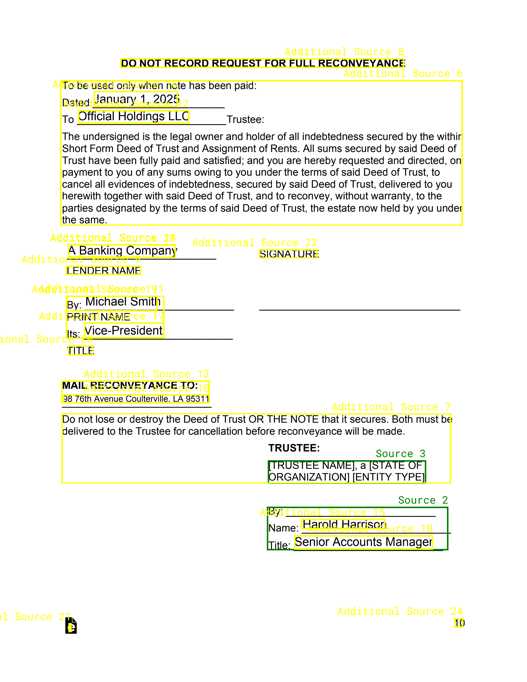

In [222]:
extraction_bot("""
key = trustor, value is a string containing the name of the trustor
key = trustor_state, value is a string with the full name of the state of the trustor
key = trustor_city, value is a string with the city of the trustors address
key = trustor_county, value is a string with the country of the filing
key = trustor_address, value is a string with the streat address of the trustor
key = lender, value is a string with the name of the lendor
key = trustee, value is a string with the name of the trustee
""", DISTANCE = 1)